In [1]:
import pandas as pd
import os
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate

# 📂DATA : 2 Classes

In [2]:
fold = 1

In [3]:
path = "/home/kannika/code/Rheology2023/Rheology_Blood/DataBlood_Viscosity_TrainML_6Fold_split2class.csv"
data_feature = pd.read_csv(path)
print(data_feature.shape)
print("-"*100)
print(f"All Fold : {set(data_feature.fold)}")
## Split Train data Set
feature_train = data_feature[data_feature["fold"]!=fold].reset_index(drop=True)
print(f"Train Set : Fold ==> {set(feature_train.fold)}")
print("Train = ", feature_train.shape)
## Split Valid data Set
feature_valid = data_feature[data_feature["fold"]==fold].reset_index(drop=True)
print(f"Valiadtion Set : Fold ==> {set(feature_valid.fold)}")
print("Validation = ", feature_valid.shape)
## Print DataFrame
feature_valid.head()

(51, 9)
----------------------------------------------------------------------------------------------------
All Fold : {1, 2, 3, 4, 5, 6}
Train Set : Fold ==> {2, 3, 4, 5, 6}
Train =  (42, 9)
Valiadtion Set : Fold ==> {1}
Validation =  (9, 9)


,Unnamed: 0,Code,classes,subclass,fold,classes_binary,MCV,MCH,Hb
0,0,HN35,HN,No_Splenectomy,1,1.0,74.3,23.4,7.1
1,1,HN43,HN,No_Splenectomy,1,1.0,57.4,17.7,4.4
2,2,HN38,HN,No_Splenectomy,1,1.0,72.9,22.6,8.0
3,3,NBL14,NBL,Normal,1,0.0,86.8,28.1,13.2
4,4,NBL15,NBL,Normal,1,0.0,88.2,27.9,13.9


In [4]:
X_test = feature_valid[['MCV','MCH','Hb']]
y_test = feature_valid["classes"]
print(X_test.shape)
print(y_test.shape)
print(y_test[0])

(9, 3)
(9,)
HN


In [5]:
print(len(set(y_test)))
print(set(y_test))

2
{'NBL', 'HN'}


## 🚀Load Model

In [6]:
#load model
import pickle

model_path = "/media/tohn/HDD/rheology2023/ML_Model/Blood_Viscosity/_2Classes/fold1/XGboost_Model_Blood2Class_fold1.pkl"
with open(model_path, 'rb') as file:
    model = pickle.load(file)

In [7]:
import numpy as np

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
print(len(y_pred))
print(y_pred)

prob_list = list()
for i in range(0,len(y_prob)):
    result = y_prob[i]
    maxx = np.argmax(result)
    prob_i = result[maxx]
    prob_list.append(prob_i)
print(len(prob_list))

9
['HN' 'HN' 'HN' 'NBL' 'NBL' 'NBL' 'HN' 'HN' 'HN']
9


In [8]:
print(prob_list)

[0.78898144, 0.78898144, 0.78898144, 0.7622222, 0.7622222, 0.7622222, 0.78898144, 0.78898144, 0.78898144]


In [9]:
feature_valid['Category'] = y_pred
feature_valid['Prob'] = prob_list
feature_valid.head()

,Unnamed: 0,Code,classes,subclass,fold,classes_binary,MCV,MCH,Hb,Category,Prob
0,0,HN35,HN,No_Splenectomy,1,1.0,74.3,23.4,7.1,HN,0.788981
1,1,HN43,HN,No_Splenectomy,1,1.0,57.4,17.7,4.4,HN,0.788981
2,2,HN38,HN,No_Splenectomy,1,1.0,72.9,22.6,8.0,HN,0.788981
3,3,NBL14,NBL,Normal,1,0.0,86.8,28.1,13.2,NBL,0.762222
4,4,NBL15,NBL,Normal,1,0.0,88.2,27.9,13.9,NBL,0.762222


In [10]:
act = feature_valid['classes'].tolist()
pred = feature_valid['Category'].tolist()
#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
# confusion_matrix(act, pred)
cmat = confusion_matrix(act, pred)
print('Classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))
print("="*100)
print(classification_report(act, pred))#performance

Classifier accuracy = 100.0%
              precision    recall  f1-score   support

          HN       1.00      1.00      1.00         6
         NBL       1.00      1.00      1.00         3

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



Text(0.5, 21.5, 'Predicted label')

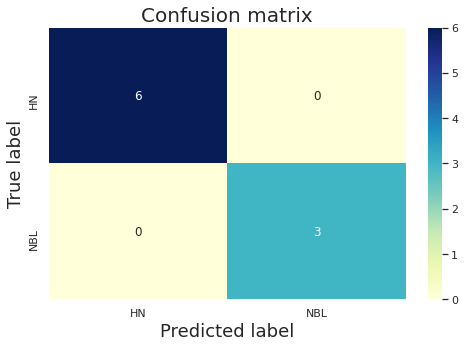

In [11]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)